In [1]:
import dann_model as dann
import training_helper as th
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image
import torchvision.models as models
import copy
from torchvision.utils import save_image
import PIL
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import math

In [2]:
device = th.getCudaDevice(cudaNum = 0, torchSeed = 123)
batch_size = 1024
my_net = dann.CNNModel().to(device)
optimizer = optim.Adam(my_net.parameters(), lr=1e-3)

Device used: cuda:0


In [3]:
img_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

mnist_train = th.labelImgData(root='hw3_data/digits/mnistm/train', transform=img_transform)
mnist_test = th.labelImgData(root='hw3_data/digits/mnistm/test', transform=img_transform)
svhn_train = th.labelImgData(root='hw3_data/digits/svhn/train', transform=img_transform)
svhn_test = th.labelImgData(root='hw3_data/digits/svhn/test', transform=img_transform)
usps_train = th.labelImgData(root='hw3_data/digits/usps/train', transform=img_transform)
usps_test = th.labelImgData(root='hw3_data/digits/usps/test', transform=img_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=0)
svhn_train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=True, num_workers=0)
svhn_test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=False, num_workers=0)
usps_train_loader = DataLoader(usps_train, batch_size=batch_size, shuffle=True, num_workers=0)
usps_test_loader = DataLoader(usps_test, batch_size=batch_size, shuffle=False, num_workers=0)

In [4]:
def test(dataloader):
    my_net.eval()
    correct = 0
    for batch_idx, (img, label) in enumerate(dataloader):
        img, label = img.to(device), label.to(device)
        output, _ = my_net(img)
        _, pred = torch.max(output, 1)
        correct += (pred == label).sum()
    return correct.item() / len(dataloader.dataset) 

In [5]:
# question 1
sourceList = ['usps', 'mnist', 'svhn']
targetList = [mnist_test_loader, svhn_test_loader, usps_test_loader]
for i in range(3):
    src, test_loader = sourceList[i], targetList[i]
    fn = 'p3_'+src+'_best.pth'
    th.loadModel(fn , my_net, optimizer)
    print(fn,'\tlower bound accuracy: {:.4f}'.format(test(test_loader)))
    fn = 'p3_'+src+'_final.pth'
    th.loadModel(fn , my_net, optimizer)
    print(fn,'\tlower bound accuracy: {:.4f}'.format(test(test_loader)),'\n')

model loaded from p3_usps_best.pth
p3_usps_best.pth 	lower bound accuracy: 0.5699
model loaded from p3_usps_final.pth
p3_usps_final.pth 	lower bound accuracy: 0.5699 

model loaded from p3_mnist_best.pth
p3_mnist_best.pth 	lower bound accuracy: 0.2732
model loaded from p3_mnist_final.pth
p3_mnist_final.pth 	lower bound accuracy: 0.3278 

model loaded from p3_svhn_best.pth
p3_svhn_best.pth 	lower bound accuracy: 0.6158
model loaded from p3_svhn_final.pth
p3_svhn_final.pth 	lower bound accuracy: 0.6158 



In [6]:
# question 2
sourceList = ['usps', 'mnistm', 'svhn', 'usps']
targetList = [mnist_test_loader, svhn_test_loader, usps_test_loader]
for i in range(3):
    src, tgt, test_loader = sourceList[i], sourceList[i+1], targetList[i]
    fn = 'p3_'+src+'->'+tgt+'_best.pth'
    th.loadModel(fn , my_net, optimizer)
    print(fn,'\tdomain adaptation accuracy: {:.4f}'.format(test(test_loader)))
    fn = 'p3_'+src+'->'+tgt+'_final.pth'
    th.loadModel(fn , my_net, optimizer)
    print(fn,'\tdomain adaptation accuracy: {:.4f}'.format(test(test_loader)),'\n')

model loaded from p3_usps->mnistm_best.pth
p3_usps->mnistm_best.pth 	domain adaptation accuracy: 0.4585
model loaded from p3_usps->mnistm_final.pth
p3_usps->mnistm_final.pth 	domain adaptation accuracy: 0.4553 

model loaded from p3_mnistm->svhn_best.pth
p3_mnistm->svhn_best.pth 	domain adaptation accuracy: 0.5071
model loaded from p3_mnistm->svhn_final.pth
p3_mnistm->svhn_final.pth 	domain adaptation accuracy: 0.4387 

model loaded from p3_svhn->usps_best.pth
p3_svhn->usps_best.pth 	domain adaptation accuracy: 0.5964
model loaded from p3_svhn->usps_final.pth
p3_svhn->usps_final.pth 	domain adaptation accuracy: 0.5092 



In [7]:
# question 3
sourceList = ['usps', 'mnist', 'svhn']
targetList = [usps_test_loader, mnist_test_loader, svhn_test_loader]
for i in range(3):
    src, test_loader = sourceList[i], targetList[i]
    fn = 'p3_'+src+'_best.pth'
    th.loadModel(fn , my_net, optimizer)
    print(fn,'\tupper bound accuracy: {:.4f}'.format(test(test_loader)))
    fn = 'p3_'+src+'_final.pth'
    th.loadModel(fn , my_net, optimizer)
    print(fn,'\tupper bound accuracy: {:.4f}'.format(test(test_loader)),'\n')

model loaded from p3_usps_best.pth
p3_usps_best.pth 	upper bound accuracy: 0.9651
model loaded from p3_usps_final.pth
p3_usps_final.pth 	upper bound accuracy: 0.9651 

model loaded from p3_mnist_best.pth
p3_mnist_best.pth 	upper bound accuracy: 0.9735
model loaded from p3_mnist_final.pth
p3_mnist_final.pth 	upper bound accuracy: 0.9631 

model loaded from p3_svhn_best.pth
p3_svhn_best.pth 	upper bound accuracy: 0.9019
model loaded from p3_svhn_final.pth
p3_svhn_final.pth 	upper bound accuracy: 0.9019 



In [8]:
# question 4 funcs
def getLatentVectorList(src_loader, tgt_loader):
    my_net.eval()
    with torch.no_grad():
        img_src, label_src = iter(src_loader).next()
        img_tgt, label_tgt = iter(tgt_loader).next()
        
        ratio = math.sqrt(len(src_loader.dataset)/len(tgt_loader.dataset))
        if ratio < 1:
            length = int(ratio*len(img_tgt))
            img_src, label_src = img_src[:length], label_src[:length]
        else:
            length = int(len(img_src)/ratio)
            img_tgt, label_tgt = img_tgt[:length], label_tgt[:length]
        
        feature = my_net.feature(img_src.to(device))
        feature = feature.view(-1, 50 * 4 * 4)
        latentVectorList = [feat.cpu().numpy() for feat in feature]
        
        feature = my_net.feature(img_tgt.to(device))
        feature = feature.view(-1, 50 * 4 * 4)
        latentVectorList += [feat.cpu().numpy() for feat in feature]
        
        labelList = label_src.cpu().numpy().tolist() + label_tgt.cpu().numpy().tolist()
        domainList = np.ones(len(img_src)).tolist() + np.zeros(len(img_tgt)).tolist()
    return np.array(latentVectorList), np.array(labelList), np.array(domainList)

def plotLabelingTSNE(args, ax):
    latentVectorList, labelList, domainList = args
    latentVectorList = TSNE(init='random', random_state = 5).fit_transform(latentVectorList)
    cm = plt.get_cmap('gist_rainbow')
    for label in range(10):
        color = cm(1.*label/10)
        xy = np.array([vec for i, vec in enumerate(latentVectorList) if label == labelList[i]])
        ax[0].scatter(xy[:,0], xy[:,1],s = 8, color = color, label = str(label), alpha = 0.9)
        ax[0].legend()
    for domain in range(2):
        color, gender = ("cornflowerblue", "source domain") if domain else ("hotpink", "target domain")
        xy = np.array([vec for i, vec in enumerate(latentVectorList) if domain == domainList[i]])
        ax[1].scatter(xy[:,0], xy[:,1],s = 8, color = color, label = gender, alpha = 0.9)
        ax[1].legend()

model loaded from p3_usps->mnistm_final.pth
model loaded from p3_mnistm->svhn_final.pth
model loaded from p3_svhn->usps_final.pth


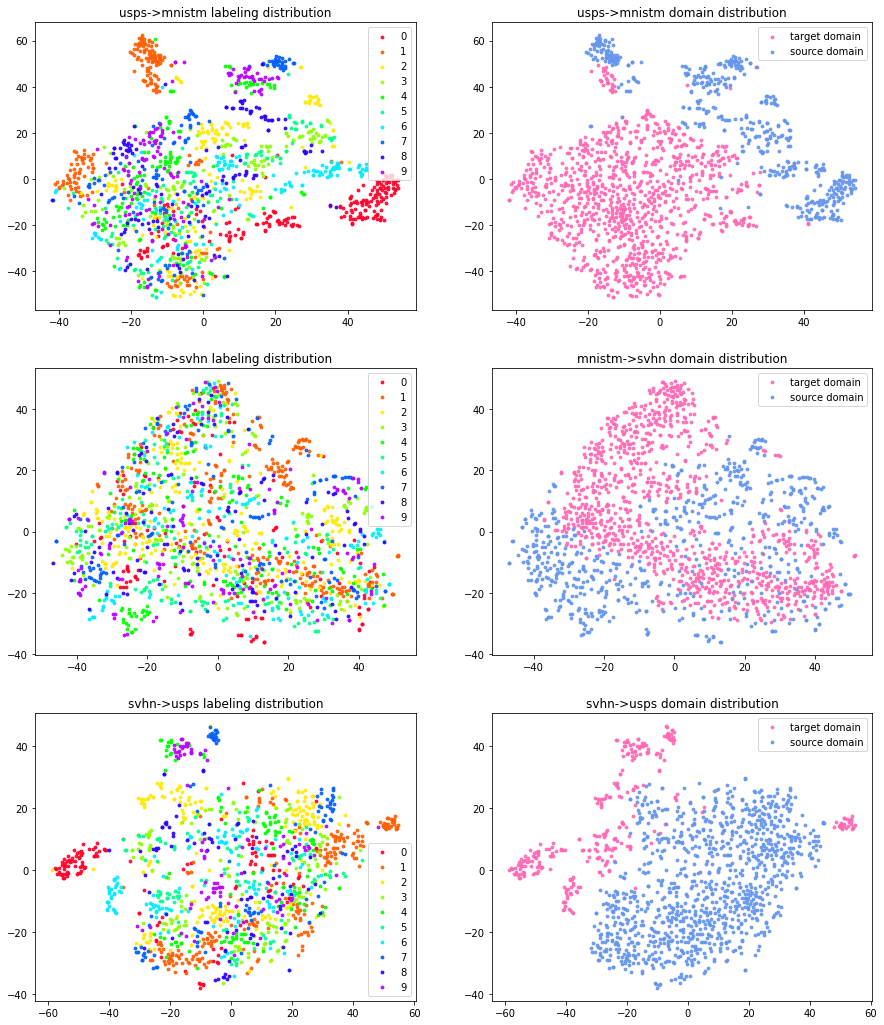

In [9]:
# question 4 repo
fig, ax = plt.subplots(3,2,figsize=(15,18))
srcStrList, srcLoadList = ['usps','mnistm','svhn'], [usps_test_loader, mnist_test_loader, svhn_test_loader]
tgtStrList, tgtLoadList = ['mnistm','svhn','usps'], [mnist_test_loader, svhn_test_loader, usps_test_loader]
stringLoaderTupleList = zip(srcStrList, srcLoadList, tgtStrList, tgtLoadList)

for i, args in enumerate(stringLoaderTupleList):
    srcStr, srcLoad, tgtStr, tgtLoad = args
    th.loadModel('p3_'+srcStr+'->'+tgtStr+'_final.pth' , my_net, optimizer)
    plotLabelingTSNE(getLatentVectorList(srcLoad, tgtLoad), ax[i])
    ax[i][0].set_title(srcStr+'->'+tgtStr+' labeling distribution')
    ax[i][1].set_title(srcStr+'->'+tgtStr+' domain distribution')
    
plt.savefig("hw3_data/p3_report/question4.jpg")
plt.show()

model loaded from p3_usps->mnistm_best.pth
model loaded from p3_mnistm->svhn_best.pth
model loaded from p3_svhn->usps_best.pth


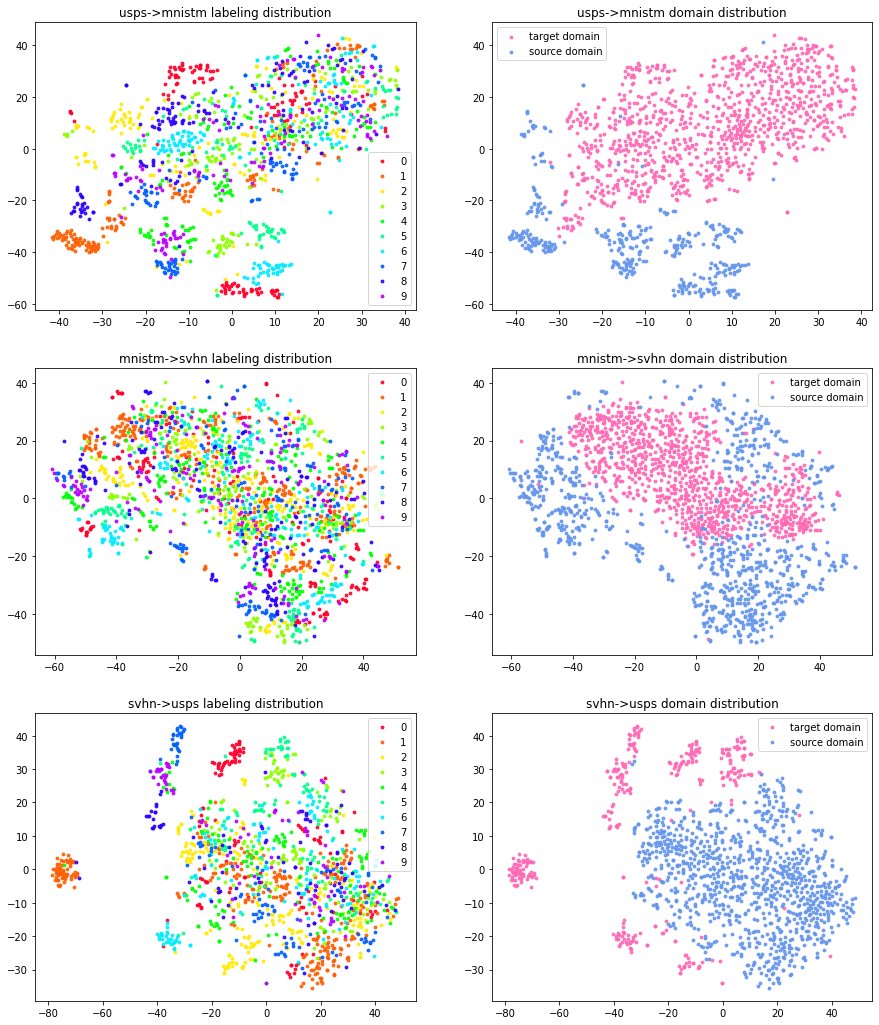

In [10]:
# question 4 best on train set
fig, ax = plt.subplots(3,2,figsize=(15,18))
srcStrList, srcLoadList = ['usps','mnistm','svhn'], [usps_train_loader, mnist_train_loader, svhn_train_loader]
tgtStrList, tgtLoadList = ['mnistm','svhn','usps'], [mnist_train_loader, svhn_train_loader, usps_train_loader]
stringLoaderTupleList = zip(srcStrList, srcLoadList, tgtStrList, tgtLoadList)

for i, args in enumerate(stringLoaderTupleList):
    srcStr, srcLoad, tgtStr, tgtLoad = args
    th.loadModel('p3_'+srcStr+'->'+tgtStr+'_best.pth' , my_net, optimizer)
    plotLabelingTSNE(getLatentVectorList(srcLoad, tgtLoad), ax[i])
    ax[i][0].set_title(srcStr+'->'+tgtStr+' labeling distribution')
    ax[i][1].set_title(srcStr+'->'+tgtStr+' domain distribution')
    
plt.savefig("hw3_data/p3_report/question4_best.jpg")
plt.show()